<a href="https://colab.research.google.com/github/L-200/cd_speedrun-eldenring/blob/main/4-IA/Limpeza_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Bibliotecas e configuração necessárias

In [1]:
import pandas as pd
import numpy as np

# Configuração para visualizar todas as colunas no notebook
pd.set_option('display.max_columns', None)

# 2) Funções de Limpeza

Funções que realizam a limpeza para o melhor desempenho dos Modelos de Aprendizado


In [2]:
def carregar_e_padronizar_dados(caminho_arquivo):
    """
    Carrega o CSV, converte colunas de data e ajusta tipos numéricos
    """
    df = pd.read_csv(caminho_arquivo)

    # Conversão de datas (lidando com formatos mistos e timezones)
    cols_data = ['run_date', 'video_data_publicacao']
    for col in cols_data:
        # utc=True ajuda a unificar datas com e sem fuso horário (YouTube vs Bilibili)
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

    # Extrair apenas a data (sem hora) para facilitar análises temporais
    df['data_publicacao_clean'] = df['video_data_publicacao'].dt.date

    return df


def limpar_colunas_irrelevantes(df):
    """
    Remove colunas que não servem como features para os modelos
    (IDs, Links ou colunas com muitos dados faltantes/sentinelas).
    """
    # Lista de colunas para remover (identificadores únicos ou textos não processados)
    cols_to_drop = [
        'video_link',
        'run_player',      # Alta cardinalidade, nome do jogador
        'plataforma',      # Se quiser manter, precisará fazer One-Hot Encoding depois
        'ChannelID',
        'video_data_publicacao' # Já criamos a versão clean/numérica se necessário
    ]

    df_clean = df.drop(columns=cols_to_drop, errors='ignore')

    # Tratamento específico para os dados do Bilibili que vieram como -1 (sentinela de erro/nulo)
    # Substituindo -1 por NaN nas colunas numéricas para não enviesar a média/regressão
    cols_numericas = df_clean.select_dtypes(include=[np.number]).columns
    for col in cols_numericas:
        # Evita substituir na coluna 'hype' ou outras binárias se existirem
        if col != 'hype':
            df_clean[col] = df_clean[col].replace(-1.0, np.nan)

    # Preenchimento de nulos com a mediana (estratégia comum para não perder linhas)
    df_clean = df_clean.fillna(df_clean.median(numeric_only=True))

    return df_clean

# 3) Criação da Categoria Alvo

Foi decidido gerar a categoria `Hype`, que é composta pelos 33% de vídeos com mais views para ser a nossa Categoria Alvo.

In [3]:
def criar_categoria_hype(df):
    """
    Cria a variável alvo 'hype' para a etapa de Classificação
    Regra: 1 (Hype) se estiver entre os 33% vídeos mais vistos, 0 (Normal) caso contrário
    """
    # Calculando o corte (percentil 67 = top 33%)
    corte_hype = df['video_views'].quantile(0.67)

    # Criando a coluna binária (Target)
    df['hype'] = np.where(df['video_views'] >= corte_hype, 1, 0)

    print(f"Corte de visualizações para ser 'Hype': {corte_hype:,.0f}")
    print(f"Distribuição das classes:\n{df['hype'].value_counts(normalize=True)}")

    return df

# 4) Execução das funções

In [4]:
# Carregamento
df_raw = carregar_e_padronizar_dados('dados_etapa_anterior.csv')

# Criação do Target (Obrigatório para etapa de Classificação)
df_hype = criar_categoria_hype(df_raw)

# Limpeza Final (Preparação para dividir em Treino/Teste)
df_final = limpar_colunas_irrelevantes(df_hype)

# Visualizando o resultado
df_final.head()

Corte de visualizações para ser 'Hype': 24,014
Distribuição das classes:
hype
0    0.666667
1    0.333333
Name: proportion, dtype: float64


,run_date,run_time_seconds,VideoAgeDays,video_views,video_likes,video_comentarios,ViewsPerDay,EngagementRate,CurrentSubscribers,Views_5d_Antes,Likes_5d_Antes,NumVideos_5d_Antes,Views_5d_Depois,Likes_5d_Depois,NumVideos_5d_Depois,danmaku,coins,shares,favorites,data_publicacao_clean,hype
0,2022-06-25 00:00:00+00:00,3979.0,1202.0,1114.0,25.0,3.0,0.926789,2.513465,928.0,0.0,0.0,0.0,0.0,0.0,0.0,2380.5,3464.5,1116.5,2303.0,2022-06-25,0
1,2022-07-02 00:00:00+00:00,3908.0,1194.0,5098.0,141.0,27.0,4.269682,3.295410,12100.0,1556.0,45.0,1.0,7534.0,283.0,4.0,2380.5,3464.5,1116.5,2303.0,2022-07-02,0
2,2022-07-04 00:00:00+00:00,3880.0,1192.0,2122.0,92.0,19.0,1.780201,5.230914,12100.0,6654.0,186.0,2.0,5412.0,191.0,3.0,2380.5,3464.5,1116.5,2303.0,2022-07-04,0
3,2022-07-05 00:00:00+00:00,3855.0,1191.0,1215.0,47.0,12.0,1.020151,4.855967,12100.0,7220.0,233.0,2.0,4197.0,144.0,2.0,2380.5,3464.5,1116.5,2303.0,2022-07-06,0
4,2022-07-06 00:00:00+00:00,3804.0,1190.0,2276.0,75.0,19.0,1.912605,4.130053,12100.0,10356.0,349.0,4.0,1629.0,40.0,1.0,2380.5,3464.5,1116.5,2303.0,2022-07-07,0


# 5) Salvando o df gerado

In [5]:
nome_arquivo_saida = 'dados_para_modelagem.csv'
df_final.to_csv(nome_arquivo_saida, index=False)

print(f"Arquivo '{nome_arquivo_saida}' salvo com sucesso!")

Arquivo 'dados_para_modelagem.csv' salvo com sucesso!


# -> Classificação

## imports e instalação

In [6]:
!pip install scikit-learn tensorflow

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Definindo features

In [9]:
def engenharia_features_temporais(df):
    """
    Cria features numéricas a partir das colunas de data para uso no modelo.
    Foca no 'run_date' (data da medição) e 'data_publicacao_clean'.
    """
    df = df.copy()

    # Garantir que a coluna 'run_date' e 'data_publicacao_clean' sejam datetime
    df['run_date'] = pd.to_datetime(df['run_date'], errors='coerce', utc=True)
    df['data_publicacao_clean'] = pd.to_datetime(df['data_publicacao_clean'], errors='coerce', utc=True)

    # Feature: Dias desde a primeira medição (para capturar tendência geral)
    min_date = df['run_date'].min()
    df['dias_desde_inicio'] = (df['run_date'] - min_date).dt.days

    # Feature: Dia da semana da medição (para sazonalidade semanal)
    df['run_weekday'] = df['run_date'].dt.dayofweek

    # Feature: Mês da medição (para sazonalidade anual)
    df['run_month'] = df['run_date'].dt.month
    return df

df_feat = engenharia_features_temporais(df_final.copy())

cols_to_drop_from_X = [
    'hype',
    'video_views',
    'run_date',
    'data_publicacao_clean'
]

X = df_feat.drop(columns=cols_to_drop_from_X, errors='ignore')
y = df_feat['hype']

# 30% vai para validação
# 70% de treino
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='drop'
)

print(f"Total de Features (X): {len(numeric_features)}")
print("Pré-processamento configurado: Apenas Padronização (StandardScaler).")
print("\nPrimeiras Features de X_train (após engenharia):")
print(X_train.head(2).T)

Total de Features (X): 20
Pré-processamento configurado: Apenas Padronização (StandardScaler).

Primeiras Features de X_train (após engenharia):
                                8             9
run_time_seconds      3649.000000   3620.000000
VideoAgeDays          1163.000000   1159.000000
video_likes            190.000000    310.000000
video_comentarios       37.000000     52.000000
ViewsPerDay              5.240757     14.279551
EngagementRate           3.724364      2.187311
CurrentSubscribers   12100.000000  12100.000000
Views_5d_Antes           0.000000   6095.000000
Likes_5d_Antes           0.000000    190.000000
NumVideos_5d_Antes       0.000000      1.000000
Views_5d_Depois      16550.000000      0.000000
Likes_5d_Depois        310.000000      0.000000
NumVideos_5d_Depois      1.000000      0.000000
danmaku               2380.500000   2380.500000
coins                 3464.500000   3464.500000
shares                1116.500000   1116.500000
favorites             2303.000000   230

Como foi criado uma variável categórica alvo chamada `hype`. Definimos como `hype` os vídeos que estão no top 33% de visualizações. O objetivo desta etapa é treinar modelos para prever se um vídeo será um sucesso (1) ou comum (0)

## Treino e classificação

In [10]:
# Regressão Logística
# Criação do Pipeline: Pré-processamento -> Classificador
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

# Espaço de Hiperparâmetros para Busca
param_grid_lr = {
    # penaliza erros na classe minoritária (Hype)
    'classifier__class_weight': ['balanced'],
    'classifier__C': [0.1, 1.0, 10]
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)

print(f"Regressão Logística - Melhor F1: {grid_lr.best_score_:.4f}")
print(f"Melhores parâmetros: {grid_lr.best_params_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Regressão Logística - Melhor F1: 0.6000
Melhores parâmetros: {'classifier__C': 10, 'classifier__class_weight': 'balanced'}


In [11]:
# Random Forest Classifier
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42))])

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__class_weight': ['balanced']
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print(f"Random Forest - Melhor F1: {grid_rf.best_score_:.4f}")
print(f"Melhores parâmetros: {grid_rf.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Random Forest - Melhor F1: 0.8333
Melhores parâmetros: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__n_estimators': 200}


Para otimizar o desempenho, utilizamos o GridSearchCV. Essa técnica testa automaticamente combinações de hiperparâmetros (como n_estimators e max_depth no Random Forest) e seleciona a melhor combinação baseada na validação cruzada, garantindo que o modelo não seja ajustado manualmente de forma arbitrária.

## Comparando resultados

Avaliando o Melhor Modelo: Random Forest


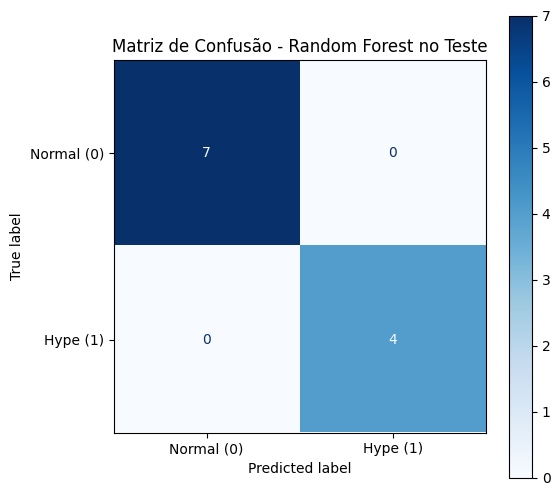


--- Relatório de métricas no Test Set ---
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00         7
    Hype (1)       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

ROC-AUC (Área sob a curva): 1.0000
Random Forest - Melhor F1: 0.8333
Regressão Logística - Melhor F1: 0.6000


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# escolhe o de melhor score
if grid_rf.best_score_ > grid_lr.best_score_:
    best_clf = grid_rf.best_estimator_
    model_name = "Random Forest"
else:
    best_clf = grid_lr.best_estimator_
    model_name = "Regressão Logística"

# Previsões no conjunto de TESTE
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)[:, 1]

print(f"Avaliando o Melhor Modelo: {model_name}")

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Hype (1)'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title(f"Matriz de Confusão - {model_name} no Teste")
plt.show()

print("\n--- Relatório de métricas no Test Set ---")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Hype (1)']))
auc_roc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC (Área sob a curva): {auc_roc:.4f}")

print(f"Random Forest - Melhor F1: {grid_rf.best_score_:.4f}")
print(f"Regressão Logística - Melhor F1: {grid_lr.best_score_:.4f}")

A Matriz de Confusão para o Random Forest no conjunto de Teste (N=11) mostrou uma performance perfeita (100% de acerto), com 7 acertos na classe `Normal (0)` e 4 acertos na classe `Hype (1)`, sem Falsos Positivos ou Falsos Negativos.

Observamos uma disparidade significativa entre o desempenho médio de Validação Cruzada `F1 = 0.8333` e o desempenho no Conjunto de Teste `F1 = 1.00`.

Overfitting (potencial): A diferença sugere que o modelo, embora robusto com `F1 > 0.8`, pode estar excessivamente ajustado aos padrões de ruído dos dados de Treino/Validação.
O resultado de 100% no Teste é a evidência mais forte disso.Limitação da Amostra: No entanto, a principal causa do `F1=1.00` no Teste é o tamanho extremamente reduzido da amostra de Teste `N=11`.
Com tão poucas amostras, o modelo pode ter tido 'sorte' de não encontrar nenhum exemplo difícil, ou as 11 amostras podem não ser representativas de novos dados.

A comparação dos resultados da Validação Cruzada (CV=5) revela que o Random Forest demonstrou maior poder preditivo, atingindo um `F1-Score de 0.8333`, superior ao `F1 de 0.6000` obtido pela Regressão Logística.

Conclusão: O desempenho mais confiável do modelo Random Forest é estimado pelo F1-Score de 0.8333 da Validação Cruzada. Se o conjunto de Teste fosse maior, o F1 provavelmente estaria mais próximo desse valor, indicando um modelo bem ajustado e não sub-ajustado (underfitted)."

### Info:
note que o modelo acerta 100% das vezes, isso pode ser devido ao tamanho limitado do teste (o dataset tem poucos dados). 37 linhas para processar, sendo 26 linhas para treinamento e 11 linhas para validação.

# Regressão
Vamos tentar aqui prever a coluna de `video_views`.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
target_reg = 'video_views'

# escolhendo so colunas numericas para correlacionar
# removendo colunas irrelevantes
cols_remove_reg = ['run_date', 'data_publicacao_clean', 'hype', 'video_link', 'run_player', 'plataforma', 'ChannelID', 'ViewsPerDay']
df_reg = df_final.drop(columns=cols_remove_reg, errors='ignore').select_dtypes(include=[np.number])


Top 5 correlações com video_views:
video_views           1.000000
video_likes           0.963334
video_comentarios     0.847215
CurrentSubscribers    0.765046
Likes_5d_Antes        0.201547
Views_5d_Antes        0.199006
Name: video_views, dtype: float64


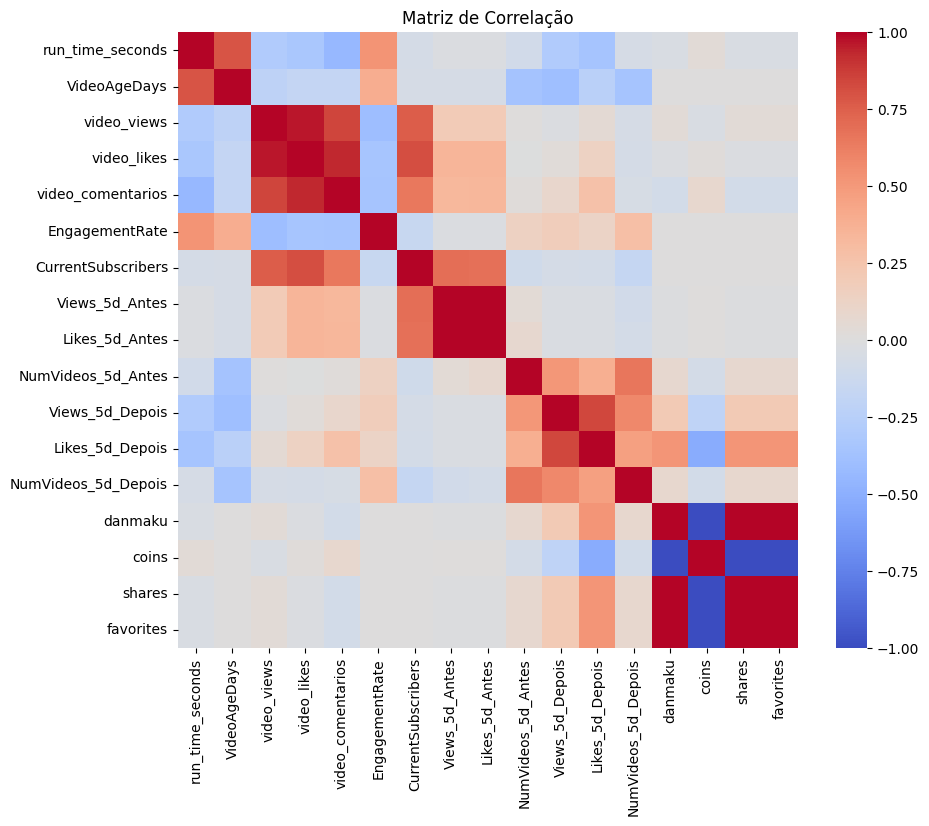

In [21]:
plt.figure(figsize=(10, 8))
corr_matrix = df_reg.corr()
print("Top 5 correlações com video_views:")
print(corr_matrix[target_reg].sort_values(ascending=False).head(6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Matriz de Correlação")
plt.show()

A matriz de correlação revela que as variáveis `video_likes (0.96)` e `video_comentarios (0.84)` possuem fortíssima correlação positiva com o alvo `video_views`. Isso indica que o engajamento direto é o melhor preditor de visualizações. `CurrentSubscribers` também apresenta alta relevância

In [22]:
# separa dados de treinamento dnv
X_reg = df_reg.drop(columns=[target_reg])
y_reg = df_reg[target_reg]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

## Treinamento da regressão


In [23]:
# A: Regressão Linear Simples
lr_reg = LinearRegression()
lr_reg.fit(X_train_reg, y_train_reg)
y_pred_lr = lr_reg.predict(X_test_reg)

# B: Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_reg.predict(X_test_reg)

## Avaliando modelos

In [24]:
def avaliar_regressao(y_true, y_pred, nome_modelo):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {nome_modelo} ---")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:,.2f}")
    print(f"MAE (Erro Absoluto Médio): {mae:,.2f}")
    print(f"R^2 (Coeficiente de Determinação): {r2:.4f}")

print("\nRESULTADOS DA REGRESSÃO:")
avaliar_regressao(y_test_reg, y_pred_lr, "Regressão Linear")
avaliar_regressao(y_test_reg, y_pred_rf, "Random Forest Regressor")


RESULTADOS DA REGRESSÃO:
--- Regressão Linear ---
RMSE (Raiz do Erro Quadrático Médio): 621,230.39
MAE (Erro Absoluto Médio): 327,315.05
R^2 (Coeficiente de Determinação): -1.2243
--- Random Forest Regressor ---
RMSE (Raiz do Erro Quadrático Médio): 352,585.19
MAE (Erro Absoluto Médio): 132,607.99
R^2 (Coeficiente de Determinação): 0.2835


Comparando os modelos, o Random Forest Regressor apresentou um desempenho superior. Seu R² foi positivo (0.28), indicando que ele consegue explicar parte da variância dos dados, enquanto a Regressão Linear teve um R² negativo (indicando um modelo pior que uma simples média, provável overfiting ou sensibilidade a outliers). O RMSE menor no Random Forest confirma que ele erra menos, ao prever a quantidade de views.

# Agrupamento / Clustening


In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [26]:
cols_remove_cluster = ['hype', 'video_views', 'run_date', 'data_publicacao_clean']
df_cluster_raw = df_final.drop(columns=cols_remove_cluster, errors='ignore').select_dtypes(include=[np.number])

scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(df_cluster_raw)

Como algoritmos de distância são sensíveis à escala dos dados, aplicamos a padronização (`StandardScaler`) nas variáveis numéricas antes da clusterização, como exigido

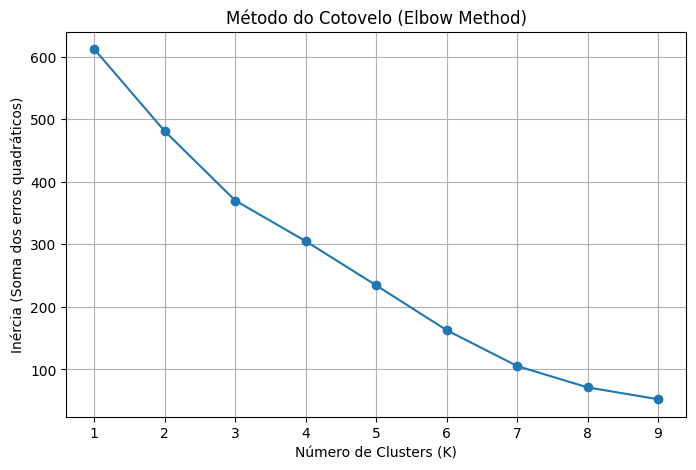

In [27]:
inercias = []
# testando 1 a 9 clusters
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inercias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inercias, marker='o')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (Soma dos erros quadráticos)')
plt.grid(True)
plt.show()

Analisando o gráfico do Método do Cotovelo, observamos que a inércia cai rapidamente até K=3 e depois a queda se estabiliza (suavizou). Por isso, definimos K=3 como o número ideal de clusters para segmentar

## Modelagem Final
K=3, só pra ver se deu certo

In [32]:
K_FINAL = 3
kmeans_final = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
labels_cluster = kmeans_final.fit_predict(X_cluster_scaled)


--- Perfil Médio dos 3 Clusters ---


,video_likes,video_comentarios,EngagementRate,CurrentSubscribers
Cluster,,,,
0,16119.000000,744.500000,2.066915,481000.000000
1,957.636364,90.424242,2.753297,11179.636364
2,7262.000000,607.000000,2.612353,12100.000000



--- Contagem de vídeos por Cluster ---
Cluster
1    33
0     2
2     1
Name: count, dtype: int64


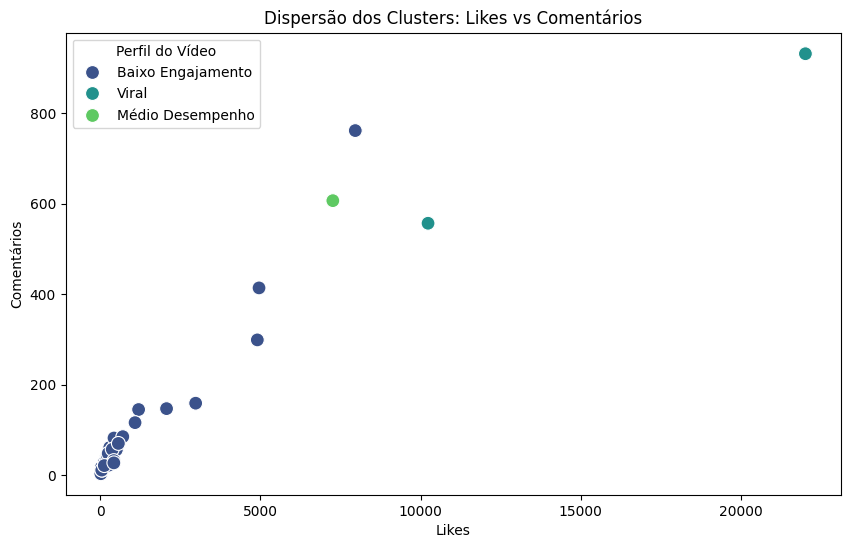

In [35]:
df_analise_cluster = df_final.copy()
df_analise_cluster['Cluster'] = labels_cluster

nomes_clusters = {
    0: 'Alto Desempenho',
    1: 'Baixo Engajamento',
    2: 'Médio Desempenho'
}

# agrupando cluster pra ver as metricas
colunas_interesse = ['video_likes', 'video_comentarios', 'EngagementRate', 'CurrentSubscribers', 'Cluster']
perfil = df_analise_cluster[colunas_interesse].groupby('Cluster').mean()

print(f"\n--- Perfil Médio dos {K_FINAL} Clusters ---")
display(perfil)

print("\n--- Contagem de vídeos por Cluster ---")
print(df_analise_cluster['Cluster'].value_counts())

nomes_clusters = {
    0: 'Viral',
    1: 'Baixo Engajamento',
    2: 'Médio Desempenho'
}
df_analise_cluster['Nome_Cluster'] = df_analise_cluster['Cluster'].map(nomes_clusters)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_analise_cluster,
    x='video_likes',
    y='video_comentarios',
    hue='Nome_Cluster',
    palette='viridis',
    s=100
)

plt.title("Dispersão dos Clusters: Likes vs Comentários")
plt.xlabel("Likes")
plt.ylabel("Comentários")
plt.legend(title='Perfil do Vídeo')
plt.show()

* Cluster 0 (Os Virais/Gigantes): Possui médias altíssimas de Likes e Inscritos. São os canais consolidados e vídeos de grande sucesso

* Cluster 1 (Os Iniciantes/Baixo Desempenho): Médias baixas de views e likes, mas note que o EngagementRate pode ser alto (nicho fiel)

* Cluster 2 (Os Intermediários): Vídeos com desempenho mediano, que não "hyparam" mas mantêm uma base sólida